## Springboard Data Science Track Capstone Project 2
### Music Genre Classification from Audio Samples
### by Morgan Fry
### Data Exploration and Inferential Statistics notebook


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline
import librosa
import librosa.display
import IPython.display as ipd

import pickle
import seaborn as sns


#### Let's start with the relevant features from one audio clip

In [2]:
audio_paths=pickle.load(open("saved/audio_paths.p","rb"))

In [3]:
ipd.Audio(audio_paths[18045],rate=22050)

In [4]:
#look at a 3-second clip
x, sr = librosa.load(audio_paths[18045],duration=10)


/home/morganfry/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


The most common visualization of sound is a plot of the amplitude envelope of the soundwave. This is equivalent to plotting the 1-d array containing the sample as a time series.  
The shape of the array is sample rate * sample length in seconds.

In [5]:
print(type(x))
print(x.shape)

<class 'numpy.ndarray'>
(220500,)


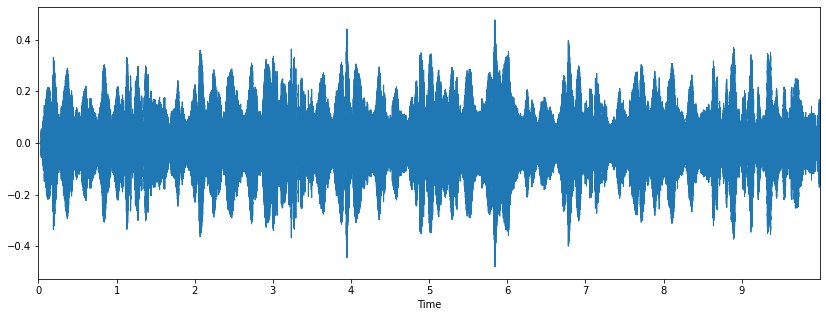

In [6]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

It is more useful for our purposes to look at the frequency spectrum. Not just how loud the entire sample is at any time but what frequencies are present.

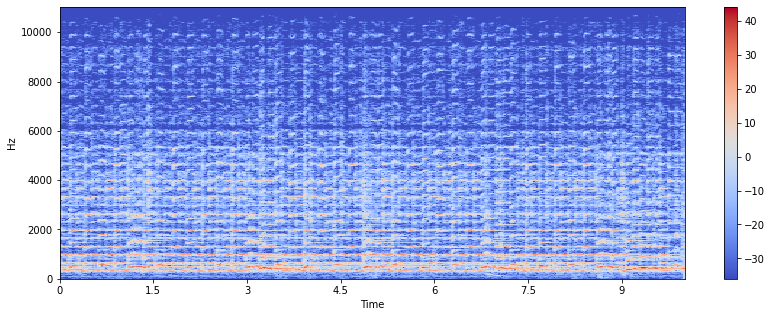

In [7]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()

Musical instruments have most of their sound in the 50-2000 Hz range, and as we can see there is a lot more information in the lower frequencies, so looking at the log of the frequencies will be more instructive.

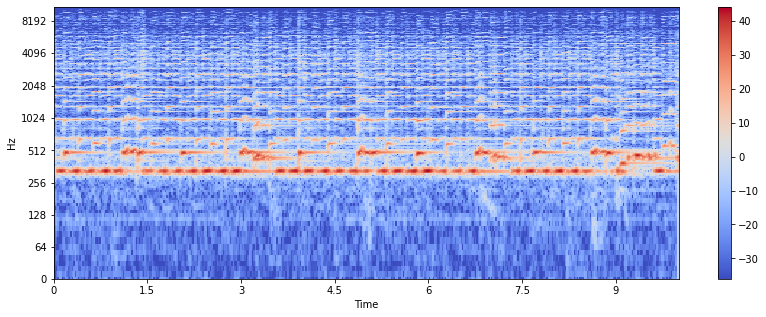

In [8]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

In this case it is a solo violin, so the open strings are from about 200Hz to about 700Hz, and we can see that most of the sound is in the 300Hz to 2000Hz range.

Even more useful is the use of Mel-frequency cepestral coefficients (MFCC). An MFCC is a representation of the power spectrum of a sound, it uses the following transformations of the signal:
* Fourier transformation of the signal
* Mapping that onto the mel scale
* Take the log of the powers at each mel frequency
* Discrete cosine transform of those log powers
  
The mel scale noted above is a scale of pitches that we perceive to be equidistant from each other. For instance every multiple of 440Hz is the note 'A', the difference between 220 and 440 is perveiced as the same as the difference between 440 and 880.

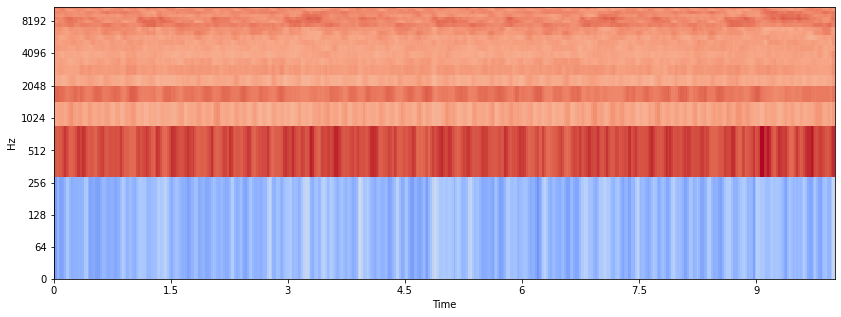

In [9]:
#MFCCs
mfccs = librosa.feature.mfcc(x, sr=sr)

plt.figure(figsize=(14,5))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', y_axis='log')
plt.show()

Given that MFCCs are a simple transformation and bear a strong relationship to how we percieve music, we will use this feature as the basis for our classification.

Let's have a look at the distribution of the classes.

In [10]:
genres=pd.read_csv('data/genres.csv', index_col=0)
genres.head()

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5


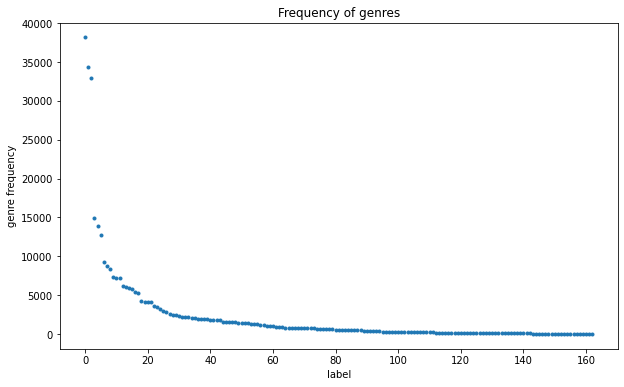

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(genres)),genres['#tracks'].sort_values(ascending=False),marker='.')
plt.title('Frequency of genres')
plt.xlabel('label')
plt.ylabel('genre frequency')
plt.show()

In [12]:
features=pd.read_csv('data/features.csv',index_col=0, header=[0,1,2])

In [13]:
tracks=pd.read_csv('data/tracks.csv',header=[0,1],index_col=0,dtype=str)

#### Let's look at the pairwise correlation between features. Because we are going to trin the model on the MFCCs, we'll look at the correlations between the various MFCC values.

In [14]:
mfccs=features['mfcc']
mfccs.head()

statistics   kurtosis                                                    \
number             01        02        03        04        05        06   
track_id                                                                  
2            3.856789  1.541901  0.000816  0.330728  0.118731 -0.342687   
3            4.296755  1.399977  0.112535 -0.211170  0.032953 -0.023489   
5            2.624517  2.415293  0.440233 -0.782131 -0.771069 -0.724216   
10           5.076893  1.161854  2.095651  1.372743 -0.203574 -0.345354   
20          11.880132  4.085320  0.002655  1.518562  0.181947  0.339014   

statistics                                          ...        std             \
number            07        08        09        10  ...         11         12   
track_id                                            ...                         
2          -0.259252  0.146735  0.410656 -0.162872  ...  10.059609   8.601942   
3           0.150404  0.046454  0.033484 -0.064596  ...   8.771966  10.026867   
5           0.090260  0.152119  0.261731 -0.608905  ...   8.863638   9.581952   
10         -0.529139  0.561974  0.281350 -0.150672  ...   8.289734   7.985110   
20          0.367611  0.069932 -0.016032  0.026012  ...   7.706648   6.498904   

statistics                                                              \
number            13        14        15        16        17        18   
track_id                                                                 
2           9.284250  9.245516  8.520863  8.560472  7.651871  7.246555   
3           6.978541  7.650417  9.600357  7.222888  8.398293  7.285423   
5           8.895723  8.141456  8.201844  7.780963  7.132692  7.539753   
10          7.075400  6.972649  7.071393  7.270959  7.051070  6.928591   
20          6.845514  6.934421  7.019398  6.983841  6.813648  7.520811   

statistics                      
number            19        20  
track_id                        
2           7.077188  7.391859  
3           7.417791  8.777440  
5           8.452527  7.334442  
10          6.430473  6.186294  
20          7.098001  7.032246  

[5 rows x 140 columns]

In [15]:
corr=mfccs.corr()
mask= np.triu(np.ones_like(corr, dtype=np.bool))

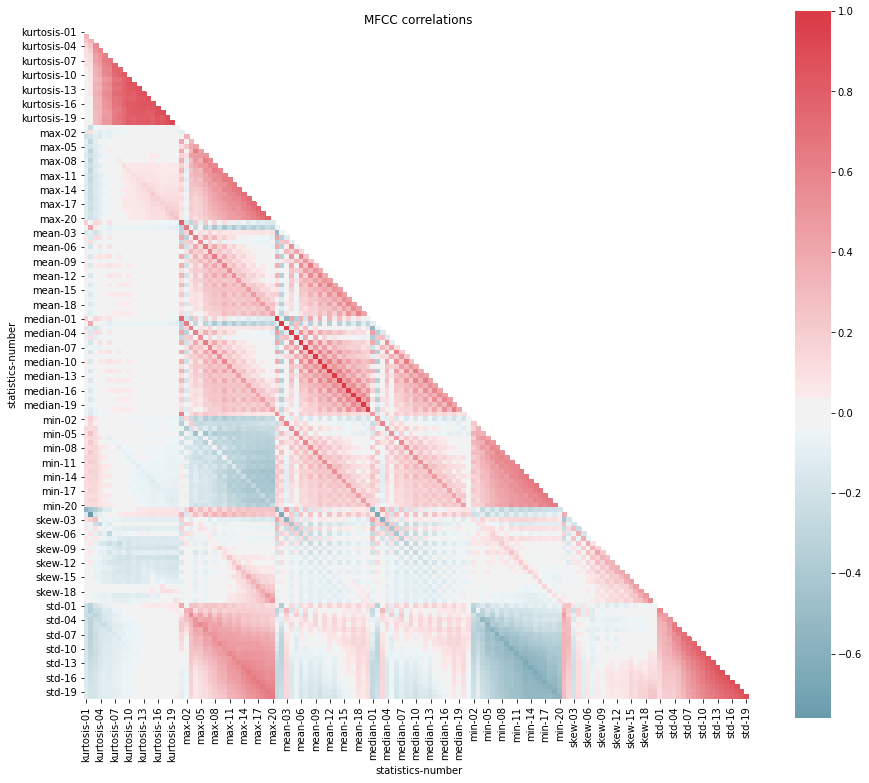

In [16]:
f, ax = plt.subplots(figsize=(15, 13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True).set_title('MFCC correlations')
plt.show()

So there is some correlation between a few sets of features. Let's single out the higher correlation pairs.

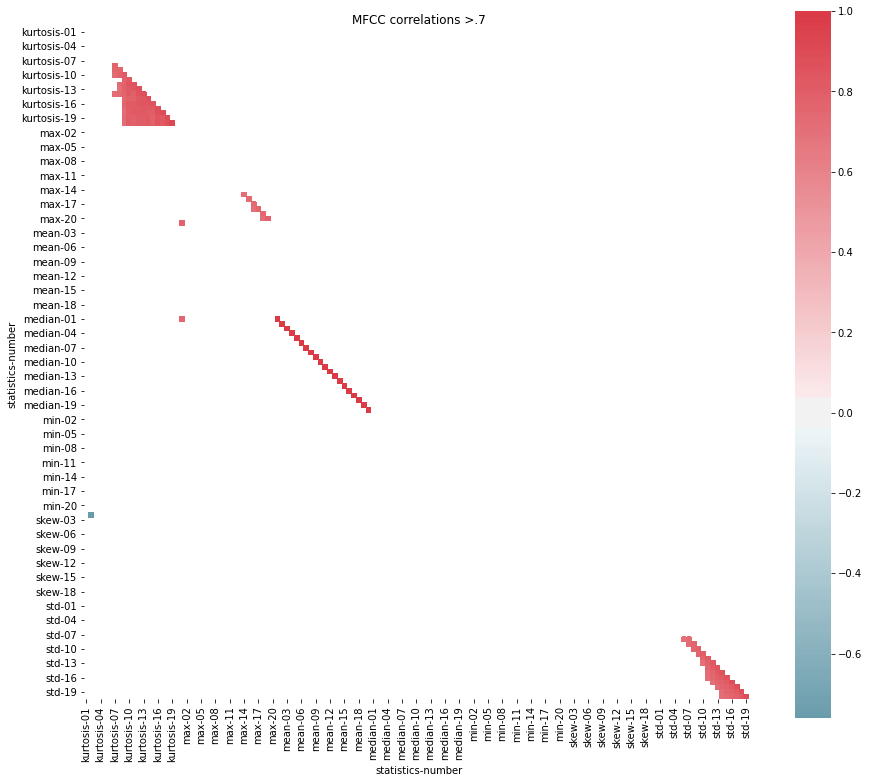

In [17]:
f, ax = plt.subplots(figsize=(15, 13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr[np.abs(corr) >= .7],
            mask=mask,
            cmap=cmap,
            center=0,
            square=True).set_title('MFCC correlations >.7')
plt.show()

In [18]:
from scipy.stats import pearsonr

print(pearsonr(corr['median','10'],corr['median','13']))
print(pearsonr(corr['kurtosis', '01'],corr['skew','01']))

(0.7061506891053277, 1.9455975724782973e-22)
(-0.8678908949263668, 9.106506051237439e-44)


We are looking at statistical features of the mfccs, such as max, min, median, skew, kurtosis, etc. From the documentation of the librosa fucntions that constructed the mfccs, we can see that they are ~23ms long, with 50% overlapping the previous and next samples. We can notice a few things from the matrix of pairwise correlations above:  
* The columns that have strong correlation are generally close to eachother. e.g. median 10 and median 13 have correlation of .706
* Most of the correlations can be attributed to nearness in time to eachother and the fact that they share some underlying data due to the sampling overlap
* Skew 03 and Kurtosis 01 are the only outliers to this pattern with a -.867 pearson coefficient.

In [19]:
corrs=np.sort(corr.values.flatten())
n_corrs=len(corrs)
p025=int(n_corrs*.025)-corr.shape[0] #offset by the self-intersections
p975=int(n_corrs*.975)-corr.shape[0]

In [20]:
p95=[corrs[p025],corrs[p975]]
print(p95)

[-0.43160941829276805, 0.6218114160318803]


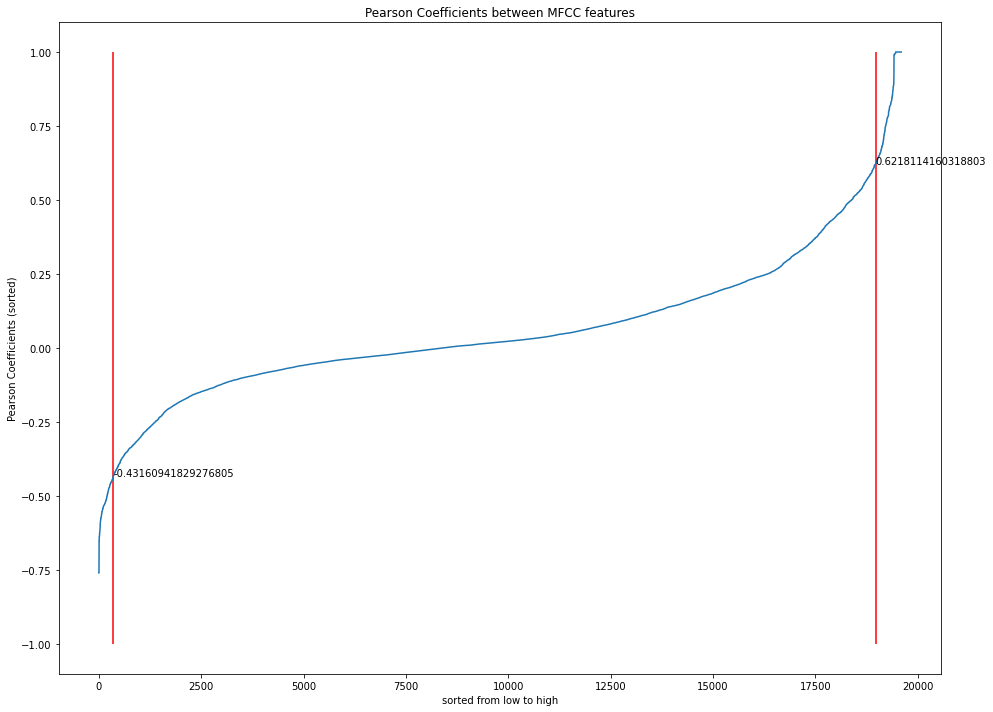

In [21]:
plt.figure(figsize=(14, 10))
plt.plot(corrs)
plt.vlines(x=p025, ymin=-1, ymax=1, label='2.5%', color='red')
plt.vlines(x=p975, ymin=-1, ymax=1, label='97.5%', color='red')
#plt.scatter(x=p025, y=p95[0], marker='o',color='black')
#plt.scatter(x=p975, y=p95[1], marker='o',color='black')
plt.annotate(p95[0],(p025,p95[0]))
plt.annotate(p95[1],(p975,p95[1]))
plt.title('Pearson Coefficients between MFCC features')
plt.xlabel('sorted from low to high')
plt.ylabel('Pearson Coefficients (sorted)')
plt.tight_layout()
plt.show()

We see that 95% of the pairwise correlations are between -.43 and .62. With only a few instances of high collinearity we may drop the highly correlated pairs if it can improve performance of the model.